<a href="https://colab.research.google.com/github/tmu-nlp/100knock2021/blob/main/wei/chapter08/knock73%EF%BD%9E79(74%E9%99%A4%E3%81%8F).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Task Description

*   knock74を除いて、knock73～knock79までのコードをここに保存済み



### 73.確率的勾配降下法による学習

確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列Wを学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）

In [1]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [13]:
# 学習用のTensor型の平均化ベクトルとラベルベクトルを変換

class NewsDataset(Dataset):
  def __init__(self, X, y):  # datasetの構成要素を指定
    self.X = X
    self.y = y

  def __len__(self):  # len(dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, idx):  # dataset[idx]で返す値を指定
    return [self.X[idx], self.y[idx]]

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv('drive/MyDrive/ColabNotebooks/NLPknock100/newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])

In [15]:
from gensim.models import KeyedVectors
import string
import torch
# 学習済み単語ベクトルを読み込む
model = KeyedVectors.load_word2vec_format('drive/MyDrive/ColabNotebooks/NLPknock100/GoogleNews-vectors-negative300.bin.gz', binary=True)

def transform_w2v(text):
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  words = text.translate(table).split()  # 記号をスペースに置換後、スペースで分割してリスト化
  vec = [model[word] for word in words if word in model]  # 1語ずつベクトル化

  return torch.tensor(sum(vec) / len(vec))  # 平均ベクトルをTensor型に変換して出力

X_train = torch.stack([transform_w2v(text) for text in train['TITLE']])
X_valid = torch.stack([transform_w2v(text) for text in valid['TITLE']])
X_test = torch.stack([transform_w2v(text) for text in test['TITLE']])

In [63]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = torch.tensor(train['CATEGORY'].map(lambda x: category_dict[x]).values)
y_valid = torch.tensor(valid['CATEGORY'].map(lambda x: category_dict[x]).values)
y_test = torch.tensor(test['CATEGORY'].map(lambda x: category_dict[x]).values)

In [64]:
#　Datasetを作成するには、X_train, y_trainを利用
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)
dataset_test = NewsDataset(X_test, y_test)

In [20]:
# Dataloaderの作成
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

* データの準備ができて、行列$W$を学習
* まず、前問と同様に、単層モデル、損失関数を定義
*　計算した勾配から重みを更新するには、optimizerをSGDに指定に定義
*　エポック数を10にして学習を実行



In [28]:
# SGLNetという単層ニューラルネットワークを定義
from torch import nn

class SGLNet(nn.Module):
  #　ネットのlayerを定義
  def __init__(self, input_size, output_size):
    super().__init__()
    self.fc = nn.Linear(input_size, output_size, bias=False)
    nn.init.normal_(self.fc.weight, 0.0, 1.0)  # 正規乱数で重みを初期化
  #　forwardで入力データが順伝播時に通るレイヤーを順に配置しておく
  def forward(self, x):
    x = self.fc(x)
    return x

In [29]:
# モデルの定義
SigleNNmodel = SGLNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義,所有optimizers都继承自torch.optim.Optimizer类，以下是例子：
# class torch.optim.Adam(params(Iterabel), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# model.parameters()返回 实际上是一个generator字典，lr是learning rate

optimizer = torch.optim.SGD(SigleNNmodel.parameters(), lr=1e-1)

In [9]:
# 学習
num_epochs = 10
for epoch in range(num_epochs):
  # 訓練モードに設定
  SigleNNmodel.train()
  loss_train = 0.0
  for i, (inputs, labels) in enumerate(dataloader_train):
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = SigleNNmodel(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # 損失を記録
    loss_train += loss.item()

  # バッチ単位の平均損失計算
  loss_train = loss_train / i

  # 検証データの損失計算
  SigleNNmodel.eval() 
  with torch.no_grad():
    inputs, labels = next(iter(dataloader_valid))
    outputs = SigleNNmodel(inputs)
    loss_valid = criterion(outputs, labels)

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}')  

epoch: 1, loss_train: 0.4676, loss_valid: 0.3629
epoch: 2, loss_train: 0.3114, loss_valid: 0.3228
epoch: 3, loss_train: 0.2813, loss_valid: 0.3145
epoch: 4, loss_train: 0.2663, loss_valid: 0.3064
epoch: 5, loss_train: 0.2556, loss_valid: 0.3057
epoch: 6, loss_train: 0.2493, loss_valid: 0.3042
epoch: 7, loss_train: 0.2436, loss_valid: 0.3126
epoch: 8, loss_train: 0.2401, loss_valid: 0.3074
epoch: 9, loss_train: 0.2354, loss_valid: 0.3028
epoch: 10, loss_train: 0.2330, loss_valid: 0.3042


### 75．損失と正解率のプロット
  
問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

In [10]:
# 各データセットの損失を計算できる関数を定義

def calculate_loss_and_accuracy(model, criterion, loader):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total

In [23]:
# 学習進捗状況を把握するため、再びDataLoaderを作成する必要があるので、73の学習操作を飛ばすべき
num_epochs = 30
log_train = []
log_valid = []
for epoch in range(num_epochs):
  # 訓練モードに設定
  SigleNNmodel.train()
  for inputs, labels in dataloader_train:
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = SigleNNmodel(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    #　損失と正解率を算出
  # 1エポック完了後、学習データと検証データ上の損失率と精度を計算
  loss_train, acc_train = calculate_loss_and_accuracy(SigleNNmodel, criterion, dataloader_train)
  loss_valid, acc_valid = calculate_loss_and_accuracy(SigleNNmodel, criterion, dataloader_valid)
  log_train.append([loss_train, acc_train])
  log_valid.append([loss_valid, acc_valid])

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}') 

epoch: 1, loss_train: 0.3315, accuracy_train: 0.8867, loss_valid: 0.3559, accuracy_valid: 0.8772
epoch: 2, loss_train: 0.2891, accuracy_train: 0.9019, loss_valid: 0.3273, accuracy_valid: 0.8885
epoch: 3, loss_train: 0.2705, accuracy_train: 0.9082, loss_valid: 0.3183, accuracy_valid: 0.8915
epoch: 4, loss_train: 0.2563, accuracy_train: 0.9129, loss_valid: 0.3100, accuracy_valid: 0.8952
epoch: 5, loss_train: 0.2505, accuracy_train: 0.9163, loss_valid: 0.3097, accuracy_valid: 0.8952
epoch: 6, loss_train: 0.2422, accuracy_train: 0.9174, loss_valid: 0.3088, accuracy_valid: 0.8960
epoch: 7, loss_train: 0.2361, accuracy_train: 0.9205, loss_valid: 0.3036, accuracy_valid: 0.8982
epoch: 8, loss_train: 0.2326, accuracy_train: 0.9200, loss_valid: 0.3075, accuracy_valid: 0.9004
epoch: 9, loss_train: 0.2286, accuracy_train: 0.9247, loss_valid: 0.3044, accuracy_valid: 0.8945
epoch: 10, loss_train: 0.2254, accuracy_train: 0.9241, loss_valid: 0.3055, accuracy_valid: 0.8952
epoch: 11, loss_train: 0.2225

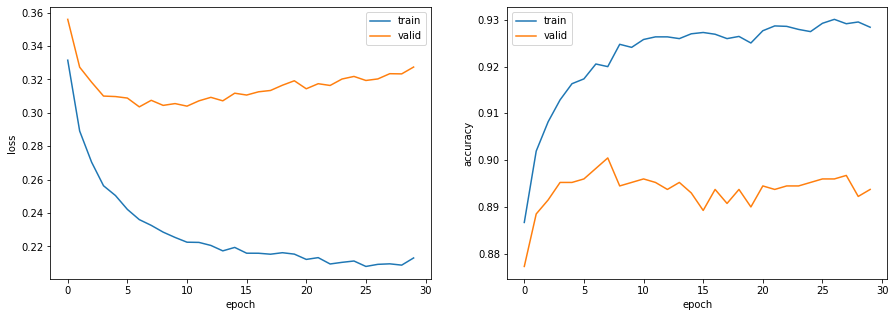

In [24]:
# 損失，正解率をグラフにプロットし，学習の進捗状況を確認
from matplotlib import pyplot as plt
import numpy as np

# 視覚化
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log_train).T[0], label='train')
ax[0].plot(np.array(log_valid).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log_train).T[1], label='train')
ax[1].plot(np.array(log_valid).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

### 76．チェックポイント
  
問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．
* 学習途中のパラメータはmodel.state_dict()、最適化アルゴリズムの内部状態はoptimizer.state_dict()でアクセス

In [25]:
# 学習
num_epochs = 10
log_train = []
log_valid = []
for epoch in range(num_epochs):
  # 訓練モードに設定
  SigleNNmodel.train()
  for inputs, labels in dataloader_train:
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = SigleNNmodel(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

  # 損失と正解率の算出
  loss_train, acc_train = calculate_loss_and_accuracy(SigleNNmodel, criterion, dataloader_train)
  loss_valid, acc_valid = calculate_loss_and_accuracy(SigleNNmodel, criterion, dataloader_valid)
  log_train.append([loss_train, acc_train])
  log_valid.append([loss_valid, acc_valid])

  # チェックポイントの保存，torch.save(dict_obj, dir)->dict_objにはエポックごとにmodel、optimizer等のargumentsを保存しておく
  torch.save({'epoch': epoch, 'model_state_dict': SigleNNmodel.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}') 

epoch: 1, loss_train: 0.2069, accuracy_train: 0.9306, loss_valid: 0.3222, accuracy_valid: 0.8937
epoch: 2, loss_train: 0.2069, accuracy_train: 0.9301, loss_valid: 0.3260, accuracy_valid: 0.8952
epoch: 3, loss_train: 0.2106, accuracy_train: 0.9285, loss_valid: 0.3292, accuracy_valid: 0.8877
epoch: 4, loss_train: 0.2062, accuracy_train: 0.9294, loss_valid: 0.3252, accuracy_valid: 0.8930
epoch: 5, loss_train: 0.2101, accuracy_train: 0.9288, loss_valid: 0.3317, accuracy_valid: 0.8915
epoch: 6, loss_train: 0.2064, accuracy_train: 0.9310, loss_valid: 0.3271, accuracy_valid: 0.8900
epoch: 7, loss_train: 0.2066, accuracy_train: 0.9297, loss_valid: 0.3292, accuracy_valid: 0.8915
epoch: 8, loss_train: 0.2053, accuracy_train: 0.9298, loss_valid: 0.3289, accuracy_valid: 0.8907
epoch: 9, loss_train: 0.2048, accuracy_train: 0.9300, loss_valid: 0.3289, accuracy_valid: 0.8930
epoch: 10, loss_train: 0.2056, accuracy_train: 0.9313, loss_valid: 0.3304, accuracy_valid: 0.8900


### 77. ミニバッチ化
  
問題76のコードを改変し，$B$事例ごとに損失・勾配を計算し，行列$W$の値を更新せよ（ミニバッチ化）．$B$の値を$1,2,4,8,…$と変化させながら，1エポックの学習に要する時間を比較せよ．
* Dataloaderの作成以降の処理をtrain_modelとして関数化し、いくつかのパラメータを引数として設定

In [37]:
import time

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs):
  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pth')

    # 終了時刻の記録
    e_time = time.time()
    timeused = e_time - s_time

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, timeused: {timeused:.4f}sec') 

  return {'train': log_train, 'valid': log_valid}

In [38]:
# モデルの学習
for batch_size in [2 ** i for i in range(11)]:
  print(f'バッチサイズ: {batch_size}')
  log = train_model(dataset_train, dataset_valid, batch_size, SigleNNmodel, criterion, optimizer, 1)

バッチサイズ: 1
epoch: 1, loss_train: 0.2343, accuracy_train: 0.9223, loss_valid: 0.3094, accuracy_valid: 0.8982, timeused: 3.8691sec
バッチサイズ: 2
epoch: 1, loss_train: 0.2264, accuracy_train: 0.9241, loss_valid: 0.3054, accuracy_valid: 0.8960, timeused: 2.1752sec
バッチサイズ: 4
epoch: 1, loss_train: 0.2244, accuracy_train: 0.9257, loss_valid: 0.3028, accuracy_valid: 0.8982, timeused: 1.1633sec
バッチサイズ: 8
epoch: 1, loss_train: 0.2240, accuracy_train: 0.9247, loss_valid: 0.3030, accuracy_valid: 0.8997, timeused: 0.6389sec
バッチサイズ: 16
epoch: 1, loss_train: 0.2237, accuracy_train: 0.9248, loss_valid: 0.3032, accuracy_valid: 0.8990, timeused: 0.4214sec
バッチサイズ: 32
epoch: 1, loss_train: 0.2236, accuracy_train: 0.9250, loss_valid: 0.3032, accuracy_valid: 0.8982, timeused: 0.2631sec
バッチサイズ: 64
epoch: 1, loss_train: 0.2236, accuracy_train: 0.9250, loss_valid: 0.3032, accuracy_valid: 0.8990, timeused: 0.1893sec
バッチサイズ: 128
epoch: 1, loss_train: 0.2233, accuracy_train: 0.9249, loss_valid: 0.3032, accuracy_valid:

### 78. GPU上での学習
問題77のコードを改変し，GPU上で学習を実行せよ．
* GPUを指定する引数deviceをcalculate_loss_and_accuracy、train_modelに追加

In [41]:
# GPUを指定し、75の損失計算関数を変えて、各データセットの損失を計算できる関数を定義

def calculate_loss_and_accuracy_GPU(model, criterion, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      # 入力TensorをGPUに送る
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total

In [42]:
# knock77の関数train_modelを改変し、deviceを指定するための引数を追加
def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  # モデルをGPUに送る
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy_GPU(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy_GPU(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint_knock78{epoch + 1}.pth')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

  return {'train': log_train, 'valid': log_valid}

In [43]:
# デバイスの指定
import torch
device = torch.device('cuda')

# モデルの学習
for batch_size in [2 ** i for i in range(11)]:
  print(f'バッチサイズ: {batch_size}')
  log = train_model(dataset_train, dataset_valid, batch_size, SigleNNmodel, criterion, optimizer, 1, device=device)

バッチサイズ: 1
epoch: 1, loss_train: 0.2308, accuracy_train: 0.9235, loss_valid: 0.3114, accuracy_valid: 0.8997, 9.4836sec
バッチサイズ: 2
epoch: 1, loss_train: 0.2219, accuracy_train: 0.9258, loss_valid: 0.3059, accuracy_valid: 0.8990, 4.8504sec
バッチサイズ: 4
epoch: 1, loss_train: 0.2208, accuracy_train: 0.9255, loss_valid: 0.3061, accuracy_valid: 0.9012, 2.4988sec
バッチサイズ: 8
epoch: 1, loss_train: 0.2197, accuracy_train: 0.9261, loss_valid: 0.3047, accuracy_valid: 0.8982, 1.3234sec
バッチサイズ: 16
epoch: 1, loss_train: 0.2196, accuracy_train: 0.9263, loss_valid: 0.3046, accuracy_valid: 0.8982, 0.7155sec
バッチサイズ: 32
epoch: 1, loss_train: 0.2196, accuracy_train: 0.9262, loss_valid: 0.3046, accuracy_valid: 0.8975, 0.4181sec
バッチサイズ: 64
epoch: 1, loss_train: 0.2195, accuracy_train: 0.9263, loss_valid: 0.3046, accuracy_valid: 0.8967, 0.2735sec
バッチサイズ: 128
epoch: 1, loss_train: 0.2196, accuracy_train: 0.9264, loss_valid: 0.3046, accuracy_valid: 0.8975, 0.1796sec
バッチサイズ: 256
epoch: 1, loss_train: 0.2200, accuracy_

### 79. 多層ニューラルネットワーク
問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．
* MLPNetを新たに定義し、入力層300 -> 中間層200 -> 出力層4の構成とし、中間層1層で、そのあとにbatch normalizationを行う
* train_model_for_MLでは、学習の打ち切り基準を導入する:検証データの損失が3エポック連続で低下しなかった場合に、打ち切るルールとする

In [65]:
# MLPNetを新たに定義
from torch import nn
from torch.nn import functional as F

class MLPNet(nn.Module):
  def __init__(self, input_size, mid_size, output_size, mid_layers):
    super().__init__()
    self.mid_layers = mid_layers
    self.fc = nn.Linear(input_size, mid_size)
    self.fc_mid = nn.Linear(mid_size, mid_size)
    self.fc_out = nn.Linear(mid_size, output_size) 
    self.bn = nn.BatchNorm1d(mid_size)

  def forward(self, x):
    x = F.relu(self.fc(x))
    for _ in range(self.mid_layers):
      x = F.relu(self.bn(self.fc_mid(x)))
    x = F.relu(self.fc_out(x))

    return x

In [83]:
def train_model_for_ML(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  # GPUに送る
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # スケジューラの設定：模块torch.optim.lr_scheduler提供了根据epoch数，调整lr的方法,即更新optimizer.param_groups[n]['lr']
  # optimizer.param_groups:list,每个元素都是一个dict，每个元素包含的关键字有:'params','lr'等
  #　一般地，设置随epoch增大减小lr。get_lr方法定义了更新策略
  # CosineAnnealingLR更新策略：让lr随epoch变化类似于cos。
  # eta_min(float):lr最小值；last_epoch(int):last epoch的index，default为-1表从头开始训练，即epoch=1
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-3, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy_GPU(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy_GPU(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint_knock79.pkl')

    # 終了時刻の記録
    e_time = time.time()
    timeused = e_time - s_time

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, timeused: {timeused:.4f}sec') 

    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    # epochごとに、optimizerを更新後、学習率を調整
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

In [90]:
# multilayerモデルの定義
MLmodel = MLPNet(300, 200, 4, 1)

# 損失関数を定義
criterion_ML = nn.CrossEntropyLoss()

#　新たにoptimizerを定義,lr=1e-3の時最良かも
optimizer_ML = torch.optim.SGD(MLmodel.parameters(), lr=1e-3)

In [91]:
# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model_for_ML(dataset_train, dataset_valid, 64, MLmodel, criterion_ML, optimizer_ML, 1000, device)

epoch: 1, loss_train: 0.9226, accuracy_train: 0.7389, loss_valid: 0.9221, accuracy_valid: 0.7433, timeused: 0.4585sec
epoch: 2, loss_train: 0.7370, accuracy_train: 0.7683, loss_valid: 0.7349, accuracy_valid: 0.7732, timeused: 0.4396sec
epoch: 3, loss_train: 0.6546, accuracy_train: 0.7795, loss_valid: 0.6540, accuracy_valid: 0.7859, timeused: 0.4569sec
epoch: 4, loss_train: 0.6106, accuracy_train: 0.7883, loss_valid: 0.6121, accuracy_valid: 0.7874, timeused: 0.4570sec
epoch: 5, loss_train: 0.5788, accuracy_train: 0.7975, loss_valid: 0.5815, accuracy_valid: 0.8001, timeused: 0.4557sec
epoch: 6, loss_train: 0.5508, accuracy_train: 0.8040, loss_valid: 0.5551, accuracy_valid: 0.8046, timeused: 0.4559sec
epoch: 7, loss_train: 0.5239, accuracy_train: 0.8151, loss_valid: 0.5297, accuracy_valid: 0.8204, timeused: 0.4443sec
epoch: 8, loss_train: 0.4965, accuracy_train: 0.8282, loss_valid: 0.5041, accuracy_valid: 0.8293, timeused: 0.4473sec
epoch: 9, loss_train: 0.4728, accuracy_train: 0.8412, lo

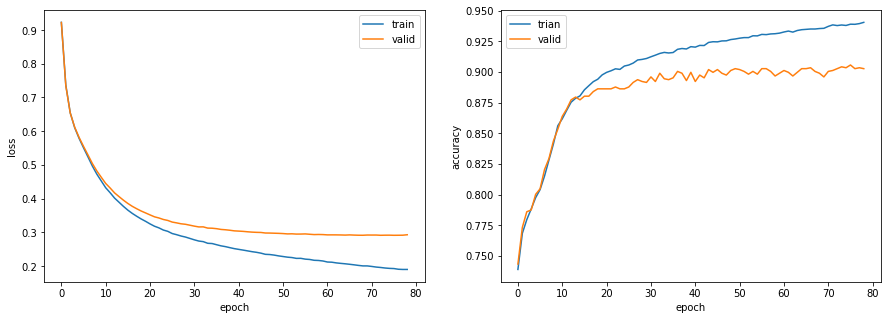

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(np.array(log['train']).T[0], label='train')
ax[0].plot(np.array(log['valid']).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log['train']).T[1], label='trian')
ax[1].plot(np.array(log['valid']).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [93]:
# 評価データの正解率を確認する関数を定義
def calculate_accuracy(model, loader, device):
  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct +=(pred == labels).sum().item()
  return correct / total

In [94]:
#　正解率を確認
acc_trian = calculate_accuracy(MLmodel, dataloader_train, device)
acc_test = calculate_accuracy(MLmodel, dataloader_test, device)
print(f'【学習データの正解率】:{acc_train:.4f}')
print(f'【評価データの正解率】:{acc_test:.4f}')

【学習データの正解率】:0.9313
【評価データの正解率】:0.9072
